<a href="https://colab.research.google.com/github/Vurimindi2021/Capstone2/blob/main/image_test_train1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


#Importing Python Libraries

In [ ]:
import os, timeit, datetime, math, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dropout, Dense, LeakyReLU, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision, SensitivityAtSpecificity, FalseNegatives, FalsePositives
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix

#Google Drive Path to Images, Checkpoint & Tensorboard Logs

In [ ]:
#Paths 
train_path = '/content/drive/MyDrive/output/train'
valid_path = '/content/drive/MyDrive/output/val'
test_path  = '/content/drive/MyDrive/output/test'
chkpt_path = '/content/drive/MyDrive/check_point'
log_path = os.path.join("/content/drive/MyDrive/logs/fit/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

#Instantiating Parameters Values

In [ ]:
classes     = ['Atelectasis','NoFinding']  # Types of Image Classifications 
batch_size  = 64*3                         # Batch Size to Process Images in ImageDataGenerator
epochs      = 25                           # Number of Epochs in ResNetV2_model.fit
train_size  = 15176                        # Number of Images in Training Dataset
val_size    = 3702                         # Number of Images in Validation Dataset
activation  = tf.keras.layers.LeakyReLU(alpha=0.01)
optimizer   = Adam(1e-3)

#Claculating Number of Steps in CNN Model.fit per Epoch for Traning and Validation

In [ ]:
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(train_size)
val_steps = compute_steps_per_epoch(val_size)

#General Elapsed Time Function

In [ ]:
start_time = timeit.default_timer()
#ImageDataGenerator
train_images = ImageDataGenerator(rotation_range = 5, 
                                  shear_range = 0.02,
                                  zoom_range = 0.02, 
                                  samplewise_center=True, 
                                  samplewise_std_normalization= True
                                  ).flow_from_directory(train_path, 
                                                        target_size=(256,256),
                                                        color_mode='grayscale',
                                                        classes=classes, 
                                                        batch_size=batch_size,
                                                        class_mode='binary',
                                                        save_format='png')                               
valid_images = ImageDataGenerator(rotation_range = 5, 
                                  shear_range = 0.02,
                                  zoom_range = 0.02, 
                                  samplewise_center=True, 
                                  samplewise_std_normalization= True
                                  ).flow_from_directory(valid_path, 
                                                        target_size=(256,256),
                                                        color_mode='grayscale',
                                                        classes=classes, 
                                                        batch_size=batch_size,
                                                        class_mode='binary',
                                                        save_format='png')  
test_images = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(256,256),
                                                        color_mode='grayscale',
                                                        classes=classes, 
                                                        batch_size=batch_size,
                                                        class_mode='binary',
                                                        save_format='png')

elapsed = timeit.default_timer() - start_time
print(elapsed)

Found 15176 images belonging to 2 classes.
Found 3702 images belonging to 2 classes.
Found 3717 images belonging to 2 classes.
69.04204146200004


#verifying Image Classes and Numeric Values Assigned for Each Class

In [ ]:
print(train_images.class_indices)
print(valid_images.class_indices)
print(test_images.class_indices)

{'Atelectasis': 0, 'NoFinding': 1}
{'Atelectasis': 0, 'NoFinding': 1}
{'Atelectasis': 0, 'NoFinding': 1}


#Printing random (25) preprocessed images in 5X5 Matrix in Training Data First Batch

In [ ]:
start_time = timeit.default_timer()
X, y = train_images.next()
elapsed = timeit.default_timer() - start_time
print(elapsed)

53.97089433000019


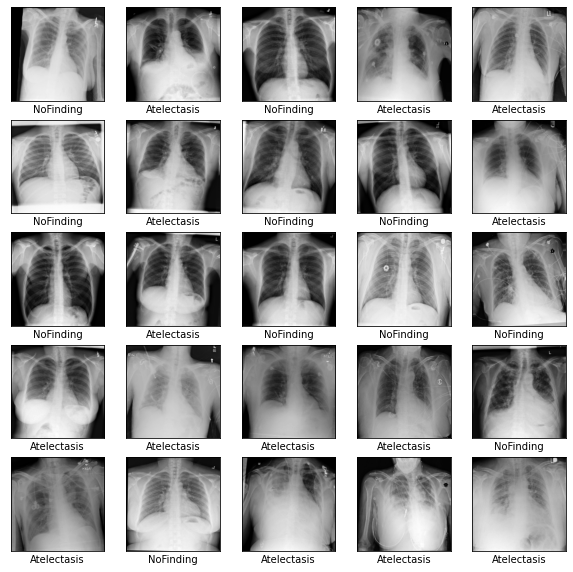

1.1344967190002535


In [ ]:
start_time = timeit.default_timer()
randimglst = random.sample([i for i in range(1,batch_size+1)], 25)
plt.figure(figsize=(10,10))
for i, image in enumerate(randimglst):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X[image][:,:,0], cmap='gray')
  plt.xlabel(classes[np.int((y[image]))])
plt.show()
elapsed = timeit.default_timer() - start_time
print(elapsed)

#Load Sequential Model, add Conv2D, AveragePooling2D, Flatten, Dropout, and Dense Layers and compile CNN Model

In [ ]:
model = Sequential()
# block 1
model.add(Conv2D(64, kernel_size=3, activation= activation, input_shape=(256,256, 1)))
model.add(AveragePooling2D(pool_size=(2,2)))
# block 2
model.add(Conv2D(96, kernel_size=3, activation= activation))
model.add(AveragePooling2D(pool_size=(2,2)))
# block 3
model.add(Conv2D(192, kernel_size=3, activation=activation))
model.add(Conv2D(192, kernel_size=3, activation=activation))
model.add(AveragePooling2D(pool_size=(2,2),strides=(2, 2)))
# block 4
model.add(Conv2D(384, kernel_size=3, activation=activation))
model.add(Conv2D(384, kernel_size=3, activation=activation))
model.add(Conv2D(384, kernel_size=3, activation=activation))
model.add(AveragePooling2D(pool_size=(2,2)))
# block 5
model.add(Conv2D(512, kernel_size=3, activation=activation))
model.add(Conv2D(512, kernel_size=3, activation=activation))
model.add(Conv2D(512, kernel_size=3, activation=activation))
model.add(AveragePooling2D(pool_size=(2,2)))
# block 5
model.add(Flatten())
model.add(Dense(128, activation=activation))
model.add(Dropout(0.5))
model.add(Dense(64, activation=activation))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
#Complie model 
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
                       metrics=[tf.keras.metrics.BinaryAccuracy(), 
                                tf.keras.metrics.Recall(), 
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.SensitivityAtSpecificity(0.5),
                                tf.keras.metrics.FalseNegatives(),
                                tf.keras.metrics.FalsePositives()
                                ])
#Print Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      640       
_________________________________________________________________
average_pooling2d (AveragePo (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 96)      55392     
_________________________________________________________________
average_pooling2d_1 (Average (None, 62, 62, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 192)       166080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 192)       331968    
_________________________________________________________________
average_pooling2d_2 (Average (None, 29, 29, 192)       0

#Load Model weights from prior training runs when When training stopped or interuppted. The model weights are saved via Checkpoint in prior training run.

In [ ]:
#model.load_weights(chkpt_path)

In [ ]:
#tf.keras.utils.plot_model(model, to_file='/content/drive/MyDrive/figs/sequential_model1.png')

#Adding callbacks.ModelCheckpoint, EarlyStopping, TensorBoard

In [ ]:
checkpoint = callbacks.ModelCheckpoint(filepath=chkpt_path,
                                    save_weights_only=True,
                                    monitor='val_binary_accuracy',
                                    mode='max',
                                    save_best_only=True)
earlystop = callbacks.EarlyStopping(monitor='val_loss', 
                                    min_delta=0.001, 
                                    patience=5, 
                                    verbose=0,
                                    mode='auto', 
                                    baseline=None, 
                                    restore_best_weights=False)
tensorboard = callbacks.TensorBoard(log_dir=log_path, 
                                    histogram_freq=1,
                                    write_graph=True)


#Train Model

In [ ]:
history=model.fit(train_images,
                  epochs=epochs,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=val_steps,
                  validation_data=valid_images,
                  callbacks=[checkpoint, earlystop, tensorboard])

#Plot Model Accuracy & Loss

dict_keys(['loss', 'binary_accuracy', 'recall_1', 'precision_1', 'sensitivity_at_specificity_1', 'false_negatives_1', 'false_positives_1', 'val_loss', 'val_binary_accuracy', 'val_recall_1', 'val_precision_1', 'val_sensitivity_at_specificity_1', 'val_false_negatives_1', 'val_false_positives_1'])


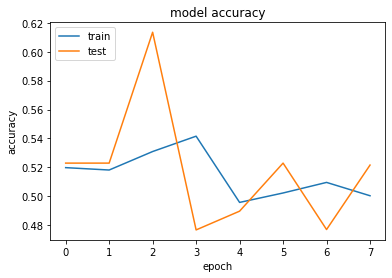

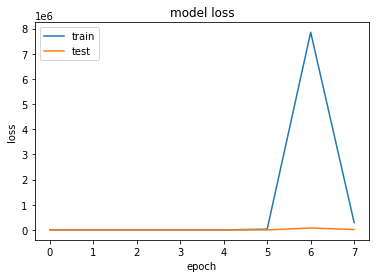

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Predict Test Image Binary Classifications with 0.5 as threshhold

In [ ]:
start_time = timeit.default_timer()
model.load_weights(chkpt_path)
elapsed = timeit.default_timer() - start_time
print(elapsed)

1.2714301410005646


In [ ]:
start_time = timeit.default_timer()
ypred = np.rint(model.predict(test_images))
y_pred=[item for sublist in ypred for item in sublist]
elapsed = timeit.default_timer() - start_time
print(elapsed)

740.8962229210001


In [ ]:
start_time = timeit.default_timer()
y_test = []
testimg_n = (test_images.n)
num_gen_calls = math.ceil(testimg_n / (1.0 * batch_size)) # 1.0 above is to skip integer division
for i in range(0,int(num_gen_calls)):
    y_test.extend(np.int(np.array(test_images[i][1])))
elapsed = timeit.default_timer() - start_time
print(elapsed)

67.94618077099994


In [ ]:
print(y_pred[y_pred==0])

1.0


#Confusion Matrix Code

In [ ]:
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix for Sequential CNN',fontsize= 20)
    ax.xaxis.set_ticklabels(['Atelectasis', 'No Finding'])
    ax.yaxis.set_ticklabels(['Atelectasis', 'No Finding'])
    plt.savefig(filename)

#Create Confusion Matrix

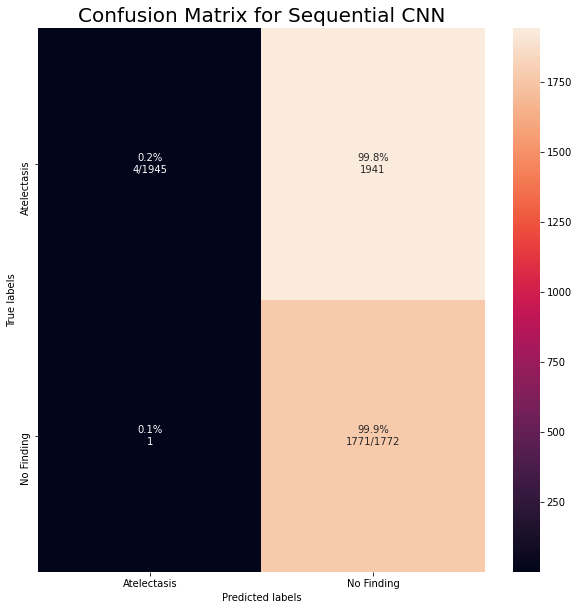

In [ ]:
labels =[0,1]
cm = confusion_matrix(y_test, y_pred, labels)
filename='/content/drive/MyDrive/figs/CM_CustomCNN.png'
cm_analysis(y_test, y_pred, filename, labels, ymap=None, figsize=(10,10))

In [ ]:
evaluate = model.evaluate(test_images)

In [ ]:
evaluate

#Printing random (25) images in 5X5 Matrix with True and Predicted Classess/ Labels

In [ ]:
start_time = timeit.default_timer()
Xt, yt = test_images.next()
elapsed = timeit.default_timer() - start_time
print(elapsed)

4.316027080998538


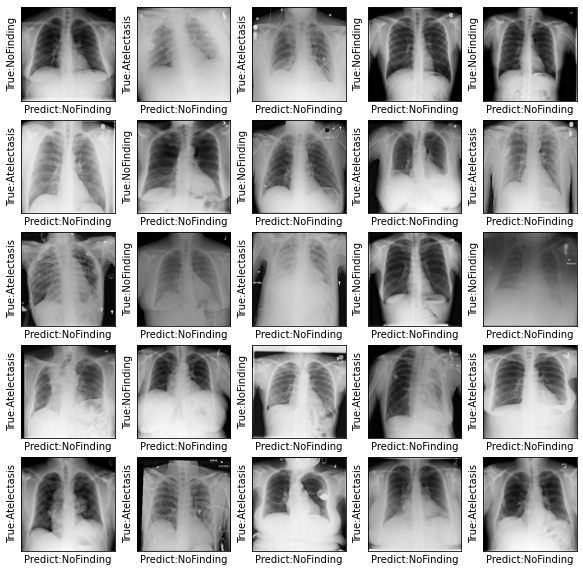

1.5814084890007507


In [ ]:
start_time = timeit.default_timer()
randimglst = random.sample([i for i in range(1,batch_size+1)], 25)
plt.figure(figsize=(10,10))
for i, image in enumerate(randimglst):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(Xt[image][:,:,0], cmap='gray')
  plt.ylabel("True:" + classes[np.int((yt[image]))])
  plt.xlabel("Predict:" + classes[np.int((y_pred[image]))])
plt.show()
elapsed = timeit.default_timer() - start_time
print(elapsed)

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard
import tensorflow as tf
import datetime
%tensorboard --logdir /content/drive/MyDrive/logs/fit/